In [1]:
import json

import shapely.geometry
import geopandas as gpd
import geopandas_osm.osm

meta_df = gpd.read_file('vectors/shanghai_image_summary.geojson')
#meta_df = gpd.read_file('vectors/shanghai_RGB_image_summary.geojson')

poly = shapely.geometry.box(*meta_df.unary_union.bounds)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [2]:
meta_df.head()

,geometry,image_name
0,"POLYGON ((121.6638792 31.3242309, 121.6638792 ...",../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...
1,"POLYGON ((121.7095092 31.2926409001, 121.70950...",../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...
2,"POLYGON ((121.7095092 31.4172459, 121.7095092 ...",../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...
3,"POLYGON ((121.7340792 31.2241959001, 121.73407...",../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...
4,"POLYGON ((121.7024892 31.2838659001, 121.70248...",../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...


## Leisure (Finding Parks)

In [15]:
leisure_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='leisure')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [17]:
leisure = leisure_df[~leisure_df.leisure.isnull()][['leisure', 'name', 'geometry']]

In [18]:
leisure.columns

Index(['leisure', 'name', 'geometry'], dtype='object')

In [19]:
from collections import Counter

In [20]:
Counter(leisure.leisure.values)

Counter({'golf_course': 3,
         'nature_reserve': 1,
         'park': 43,
         'pitch': 27,
         'sports_centre': 1,
         'swimming_pool': 1,
         'track': 4})

In [21]:
leisure.to_file('vectors/shangai_leisure_RGB.geojson', 'GeoJSON')

## Landuse (Farmland/Farmyards/Industrial/etc)

In [4]:
landuse_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='landuse')

/home/mmaresca/miniconda/envs/geo/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [5]:
landuse = landuse_df[~landuse_df.landuse.isnull()][['landuse', 'name', 'geometry']]

In [6]:
landuse.columns

Index(['landuse', 'name', 'geometry'], dtype='object')

In [7]:
#highway_centroids = highways.set_geometry(highways, inplace=False)


In [9]:
landuse.to_file('vectors/shangai_landuse_RGB.geojson', 'GeoJSON')

In [10]:
from collections import Counter

In [11]:
Counter(landuse.landuse.values)

Counter({'basin': 1,
         'commercial': 24,
         'construction': 3,
         'farmland': 18,
         'farmyard': 223,
         'forest': 17,
         'grass': 9,
         'greenfield': 1,
         'greenhouse_horticulture': 2,
         'industrial': 38,
         'meadow': 8,
         'railway': 1,
         'recreation_ground': 1,
         'religious': 1,
         'residential': 80,
         'retail': 12})

## Shanghai Nature

In [12]:
natural_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='natural')

/home/mmaresca/miniconda/envs/geo/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [13]:
natural = natural_df[~natural_df.natural.isnull()][['natural', 'name', 'geometry']]

In [14]:
natural.columns

Index(['natural', 'name', 'geometry'], dtype='object')

In [15]:
natural.to_file('vectors/shanghai_natural_RGB.geojson', 'GeoJSON')

In [16]:
Counter(natural.natural.values)

Counter({'coastline': 14,
         'sand': 1,
         'scrub': 1,
         'water': 166,
         'wetland': 1,
         'wood': 13})

# Matching OSM data to the SpaceNet images


## Shanghai Trees/Farmland

In [17]:
import os

import rasterio

image_dir_path = '../AOI_4_Shanghai_Train/MUL-PanSharpen'

tiff_images = [os.path.join(image_dir_path, image_name) 
               for image_name in os.listdir(image_dir_path) 
               if image_name.lower().endswith('tif')]

res = []
for image_file_name in tiff_images:
    with rasterio.open(image_file_name) as src:
        bbox = shapely.geometry.box(*src.bounds)
    res.append((image_file_name, bbox))
shanghai_df = gpd.GeoDataFrame(res, columns=['image_name', 'geometry'], crs={'init': 'epsg:4326'})
#poly = shapely.geometry.box(*image_summary.unary_union.bounds)

poly = shapely.geometry.box(*shanghai_df.unary_union.bounds)

osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='natural')
osm_df.set_geometry(natural.geometry.apply(shapely.geometry.Polygon), inplace=True)

nature_df = osm_df[~osm_df.natural.isnull()]
print(nature_df.natural.unique())
print(nature_df.shape)
nature_df.to_file('vectors/shanghai_nature.geojson', 'GeoJSON')

/home/mmaresca/miniconda/envs/geo/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


['coastline' 'water' 'scrub' 'wetland' 'wood' 'sand']
(196, 10)


In [19]:
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='landuse')
osm_df.set_geometry(landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)

landuse = osm_df[~osm_df.landuse.isnull()]
print(landuse.landuse.unique())
print(landuse.shape)
landuse.to_file('vectors/landuse2.geojson', 'GeoJSON')

/home/mmaresca/miniconda/envs/geo/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


['industrial' 'religious' 'residential' 'greenfield' 'commercial' 'basin'
 'construction' 'greenhouse_horticulture' 'grass' 'railway' 'forest'
 'meadow' 'farmland' 'farmyard' 'retail' 'recreation_ground']
(439, 22)


In [20]:
Counter(landuse.landuse)

Counter({'basin': 1,
         'commercial': 24,
         'construction': 3,
         'farmland': 18,
         'farmyard': 223,
         'forest': 17,
         'grass': 9,
         'greenfield': 1,
         'greenhouse_horticulture': 2,
         'industrial': 38,
         'meadow': 8,
         'railway': 1,
         'recreation_ground': 1,
         'religious': 1,
         'residential': 80,
         'retail': 12})

In [21]:
landuse;

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

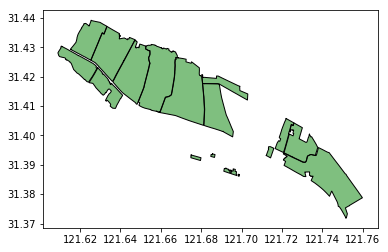

In [25]:
fig, ax = plt.subplots()
landuse[landuse.landuse == 'farmland'].plot(color='g', ax=ax)

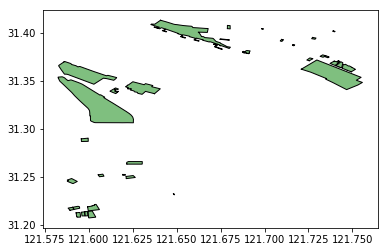

In [29]:
fig, ax = plt.subplots()
landuse[landuse.landuse == 'industrial'].plot(color='g', ax=ax)

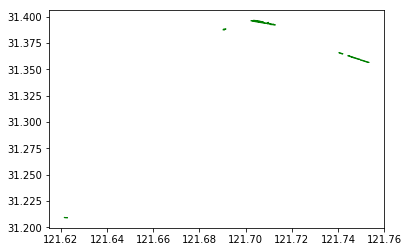

In [26]:
fig, ax = plt.subplots()
natural[natural.natural == 'wood'].plot(color='g', ax=ax)

In [25]:
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='natural')
nature = osm_df[~osm_df.natural.isnull()]
print(nature.natural.unique())
print(nature.shape)
#nature.to_file('vectors/nature2.geojson', 'GeoJSON')

/home/mmaresca/miniconda/envs/geo/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


['coastline' 'water' 'scrub' 'wetland' 'wood' 'sand']
(196, 10)


In [26]:
nature.head()

,admin_level,boat,boundary,geometry,golf,id,name,natural,water,waterway
0,6,NaN,administrative,"LINESTRING (121.7188589 31.3634878, 121.720518...",NaN,9979122,NaN,coastline,NaN,NaN
1,NaN,NaN,NaN,"LINESTRING (121.7126708 31.2927056, 121.691359...",NaN,9983239,NaN,coastline,NaN,NaN
2,NaN,NaN,NaN,"LINESTRING (121.6846559 31.3107746, 121.687418...",NaN,9984071,NaN,coastline,NaN,NaN
3,6,NaN,administrative,"LINESTRING (121.7004543 31.3731507, 121.700601...",NaN,9984387,NaN,coastline,NaN,NaN
4,6,NaN,administrative,"LINESTRING (121.5912602 31.432857, 121.591707 ...",NaN,9984493,NaN,coastline,NaN,NaN


In [9]:
# tag = 'generator:source=solar'
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='natural')
osm_df.columns

/home/mmaresca/miniconda/envs/geo/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


Index(['geometry', 'height', 'id', 'landuse', 'leisure', 'name', 'natural',
       'wetland'],
      dtype='object')

In [10]:
osm_df['landuse'].unique()

array([nan, 'farmland'], dtype=object)